# LGPEKF Attitude Filter (Lie Group Projected EKF)

This filter uses a geometrically accurate measurement correction, that is appropriate for measurements on a manifold. In this case, we measure the attitude of the vehicle relative to the magnetic field and also we measure the direction of the gravity. When the acceleration is near g, it can be assumed that the vehicle is on the ground or in a stable hover and, the direction of gravity can be use to correct the attitude.

Although the measurements are actually vectors, they are transformed into elements of SO3. One represenation of SO3 is a direction cosine matrix. From the Lie Group Extended Kalman Filter, we use a slightly modified correction term so that it is right invariant:

$$\hat{X}_{k|k} = \hat{X}_{k|k-1}\exp_{G} \left(
    K \log_{G'}\left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
\right) $$

Here $T_y$ represents the mapping of the true measurement to the manifold. Although a bijection does not exist between SO3 and the vector measurements, a map can be constructed that is closest to the original state, so that the measurements only modifies the states that it is observing. For instance, if $y$ is measuring the magnetic heading, we wish to only induce a rotation about the down direction in the navigation frame, so we choose $T_y$ so that $\eta = h(\hat{X}_{k|k-1}) T_y(y_k)^{-1} = R_3(\xi_3)$, where $R_3$ represents a rotation around the world 3 axis.

$$ H = \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee} \left(
        h(\hat{X}_{k|k-1}) T_y(y_k)^{-1}
    \right)
$$

### TODO

* Correctly handle noise on manifolds.
* Generate C code.

In [1]:
%load_ext autoreload
%autoreload 2

import sys
import os
import pandas as pd

sys.path.insert(0, '..')

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import scipy.integrate
from IPython.display import Image
from casadi.tools.graph import graph
import casadi as ca

# this library
from pyecca.so3.mrp import Mrp
from pyecca.so3.quat import Quat
from pyecca.so3.dcm import Dcm

def draw_graph(x):
    g = graph.dotgraph(x)
    #g.set('dpi', 300)
    png = g.create('dot', 'png')
    return Image(png)

## Filter Derivation

This needs to be cleaned up.

In [2]:
class SO3xR3(ca.SX):
    """
    Direct product of SO3 and R3
    """
    
    def __init__(self, *args, **kwargs):
        super().__init__(*args, **kwargs)
        assert self.shape == (6, 1)
        self.r = Mrp(self[0:3])
        self.b = self[3:6]

    def inv(self):
        return self.__class__(ca.vertcat(self.r.inv(), -self.b))
    
    def __mul__(self, other):
        r = self.r*other.r
        b  = self.b + other.b
        return self.__class__(ca.vertcat(r, b))

    @classmethod
    def exp(cls, xi):
        return cls(ca.vertcat(Mrp.exp(xi[0:3]), xi[3:6]))

    def log(self):
        return ca.vertcat(self.r.log(), self.b)

    def shadow_if_needed(self):
        r = ca.if_else(ca.norm_2(self.r) >1, self.r.shadow(), self.r)
        return self.__class__(ca.vertcat(r, self.b))

### Prediction



In [3]:
def rk4(f, t, y, h):
    """Runge Kuta 4th order integrator"""
    k1 = h*f(t, y)
    k2 = h*f(t + h/2, y + k1/2)
    k3 = h*f(t + h/2, y + k2/2)
    k4 = h*f(t + h, y + k3)
    return ca.simplify(y + (k1 + 2*k2 + 2*k3 + k4)/6)

In [4]:
n_x = 6
t = ca.SX.sym('t')
dt = ca.SX.sym('dt')
x = SO3xR3(ca.SX.sym('x', 6, 1))
x_h = SO3xR3(ca.SX.sym('x_h', 6, 1))
q = Quat(ca.SX.sym('q', 4, 1))
omega_b = ca.SX.sym('omega_b', 3, 1)

w_gyro_rw = ca.SX.sym('w_gyro_rw', 3, 1)
x_dot = ca.vertcat(x.r.derivative(omega_b - x.b), w_gyro_rw)
f_dynamics = ca.Function(
    'dynamics', [x, omega_b, w_gyro_rw],
    [x_dot],
    ['x', 'omega_b', 'w_gyro_rw'], ['x_dot'])

# can use lie gropu for integration due ot state coupling
x1 = rk4(lambda t, y: f_dynamics(y, omega_b, w_gyro_rw), t, x_h, dt)

f_predict_x = ca.Function(
    'x_predict',
    [x_h, omega_b, w_gyro_rw, dt],
    [x1],
    ['x0', 'omega_b', 'w_gyro_rw', 'dt'],
    ['x1']
    )

#### Square Root Covariance Prediction

In [5]:
def find_X(W, F, Q):
    """
    Finds a sqrt factorization of the continuous time covariance
    propagation equations. Requires solving a linear system of equations
    to keep the sqrt lower triangular.
    
    'A Square Root Formulation of the Kalman Covariance Equations', Andrews 68
    
    W: sqrt P, symbolic, with sparsity lower triangulr
    F: dynamics matrix
    Q: process noise matrix
    
    returns:
    W_dot_sol: sqrt of P deriative, lower triangular
    """
    n_x = F.shape[0]
    XL = ca.SX.sym('X', ca.Sparsity_lower(n_x))
    X = (XL - XL.T)
    for i in range(n_x):
        X[i, i] = 0
    W_dot = ca.mtimes(F, W) + ca.mtimes(Q/2 + X, ca.inv(W).T)

    # solve for XI that keeps W dot lower triangular
    y = ca.vertcat(*ca.triu(W_dot, False).nonzeros())
    x_dep = []
    for i, xi in enumerate(XL.nonzeros()):
        if ca.depends_on(y, xi):
            x_dep += [xi]
    x_dep = ca.vertcat(*x_dep)
    A = ca.jacobian(y, x_dep)
    for i, xi in enumerate(XL.nonzeros()):
        assert not ca.depends_on(A, xi)
    b = -ca.substitute(y, x_dep, 0)
    x_sol = ca.solve(A, b)

    X_sol = ca.SX(X)
    for i in range(x_dep.shape[0]):
        X_sol = ca.substitute(X_sol, x_dep[i], x_sol[i])
    X_sol = ca.sparsify(X_sol)
    W_dot_sol = ca.mtimes(F, W) + ca.mtimes(Q/2 + X_sol, ca.inv(W).T)

    return W_dot_sol

In [6]:
eta = SO3xR3(ca.SX.sym('eta', 6, 1)) # (right)
f = ca.Function('f', [eta, x_h, w_gyro_rw], [ca.vertcat(-ca.mtimes(x_h.r.to_dcm(), eta.b), w_gyro_rw)])
f_J = ca.jacobian(f(eta, x_h, w_gyro_rw), eta)

# note, the estimated error is always zero when propagating the
# covariance, we might want the F without zero eta_R, when doing
# the LGEKF covariance correction term
F = ca.sparsify(ca.substitute(f_J, eta, ca.SX.zeros(n_x)))
f_F = ca.Function('F', [x_h], [F], ['x_h'], ['F'])

std_gyro = ca.SX.sym('std_gyro')
sn_gyro_rw = ca.SX.sym('sn_gyro_rw')
std_gyro_rw = sn_gyro_rw/ca.sqrt(dt)
Q = ca.diag(ca.vertcat(std_gyro, std_gyro, std_gyro, std_gyro_rw, std_gyro_rw, std_gyro_rw))**2

#f_cond = ca.Function('cond', [x, u, PU, R], [condition_number(Si),],
#                       ['x', 'u', 'PU', 'R'], ['cond'])

W = ca.SX.sym('W', ca.Sparsity_lower(n_x))
W_dot_sol = find_X(W, F, Q)
f_W_dot = ca.Function('W_dot', [x_h, W, std_gyro, sn_gyro_rw, omega_b, dt], [W_dot_sol])
f_W_dot_lt = ca.Function('W_dot_lt', [x_h, W, std_gyro, sn_gyro_rw, omega_b, dt], [ca.tril(W_dot_sol)])
W1 = rk4(lambda t, y: f_W_dot_lt(x_h, y, std_gyro, sn_gyro_rw, omega_b, dt), t, W, dt)

f_predict_W = ca.Function(
    'predict_W',
    [x_h, W, std_gyro, sn_gyro_rw, omega_b, dt],
    [W1],
    ['x_h', 'W0', 'std_gyro', 'sn_gyro_rw', 'omega_b', 'dt'], ['W1'])

f_predict_x_W = ca.Function(
    'predict_x_W',
    [x_h, W, omega_b, std_gyro, sn_gyro_rw, dt],
    [ca.substitute(x1, w_gyro_rw, ca.SX.zeros(3)), W1],
    ['x0', 'W0', 'omega_b', 'std_gyro', 'sn_gyro_rw', 'dt'],
    ['x1', 'W1']
    )

def test_sqrt_cov_prop():
    W_check = np.random.randn(6, 6)
    Q_check = np.diag([0.1, 0.1, 0.1, 0, 0, 0])
    xh_check = np.array([0.1, 0.2, 0.3, 0.1, 0.2, 0.3])
    omega_check = np.array([1, 2, 3])
    dt_check = 0.1

    f_check = ca.Function(
        'check',
        [x_h, W, std_gyro, sn_gyro_rw, omega_b, dt],
        [ca.mtimes([F, W, W.T]) + ca.mtimes([W, W.T, F.T]) + Q - ca.mtimes(W, W_dot_sol.T) - ca.mtimes(W_dot_sol, W.T)])
    assert np.linalg.norm(f_check(xh_check, W_check, 1, 1, [1, 1, 1], 0.1)) < 1e-5
    assert np.linalg.norm(ca.triu(f_W_dot(xh_check, W_check, 1, 1, [1, 1, 1], 0.1), False)) < 1e-5

    P_test = np.eye(6)
    P_test[3, 0] = 0.1
    P_test[1, 2] = 0.3
    P_test = P_test + P_test.T
    xh_test = np.random.randn(6)
    W_test = np.linalg.cholesky(P_test)
    assert np.linalg.norm(W_test.dot(W_test.T) - P_test) < 1e-10

    W1_test = f_predict_W(xh_test, W_test, 1, 1, omega_check, dt_check)
    print('PASS')

test_sqrt_cov_prop()

PASS


### Magnetometer Correction

For the case of the magnetic heading, we calculate:

\begin{align} H_{mag} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_3(\xi_3)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \xi_3 \\
&= \begin{pmatrix} 0 & 0 & 1\end{pmatrix}
\end{align}

In [7]:
H_mag = ca.SX(1, 6)
H_mag[0, 2] = 1

decl = ca.SX.sym('decl')
incl = ca.SX.sym('incl') # only useful for sim, neglected in correction
e1 = ca.SX([1, 0, 0])
e2 = ca.SX([0, 1, 0])
e3 = ca.SX([0, 0, 1])

B_n = ca.mtimes(Dcm.exp(decl*e3)*Dcm.exp(-incl*e2), ca.SX([1, 0, 0]))
f_measure_mag = ca.Function('measure_mag', [x, decl, incl], [ca.mtimes(x.r.to_dcm().T, B_n)], ['x', 'decl', 'incl'], ['y'])
yh_mag = f_measure_mag(x_h, decl, 0)  # can ignore incl, not used
std_mag = ca.SX.sym('std_mag')
gamma = ca.acos(yh_mag[2]/ca.norm_2(yh_mag))
h = ca.fmax(ca.sin(gamma), 1e-3)

y_b = ca.SX.sym('y_b', 3, 1)

R_nb = x_h.r.to_dcm()
y_n = ca.mtimes(R_nb, y_b)

omega_c_mag_n = -ca.atan2(y_n[1], y_n[0])*ca.SX([0, 0, 1]) + decl

#### Square Root Factorization

In [8]:
def sqrt_correct(Rs, H, W):
    """
    source: Fast Stable Kalman Filter Algorithms Utilising the Square Root, Steward 98
    Rs: sqrt(R)
    H: measurement matrix
    W: sqrt(P)
    @return sqrt(P+) = sqrt((I - KH)P)
    """
    n_x = H.shape[1]
    n_y = H.shape[0]
    B = ca.sparsify(ca.blockcat(Rs, ca.mtimes(H, W), ca.SX.zeros(n_x, n_y), W))
    # qr  by default is upper triangular, so we transpose inputs and outputs
    B_Q, B_R = ca.qr(B.T)  # B_Q orthogonal, B_R, lower triangular
    B_Q = B_Q.T
    B_R = B_R.T
    K = ca.mtimes(B_R[n_y:, :n_y], ca.inv(B_R[:n_y, :n_y]))
    Wp = B_R[n_y:, n_y:]
    return Wp, K

In [9]:
std_rot = std_mag + ca.norm_2(ca.diag(W)[0:2])  # roll/pitch and mag uncertainty contrib. to projection uncertainty
Rs_mag = 2*ca.asin(std_rot/(2*h))

W_mag, K_mag = sqrt_correct(Rs_mag, H_mag, W)
x_mag = SO3xR3.exp(ca.mtimes(K_mag, omega_c_mag_n[2]))*x_h

# ignore correction when near singular point
mag_should_correct = ca.logic_and(std_rot/2 < h, ca.norm_2(ca.diag(W)[0:2]) < 0.1)
x_mag = ca.if_else(mag_should_correct, x_mag, x_h)  
W_mag = ca.if_else(mag_should_correct, W_mag, W)
f_correct_mag = ca.Function(
    'correct_mag',
    [x_h, W, y_b, decl, std_mag], [x_mag, W_mag],
    ['x_h', 'W', 'y_b', 'decl', 'std_mag'],
    ['x_mag', 'W_mag'])

def test_mag_correct():
    W_test = 0.1*np.eye(6)
    W_test[5, 0] = 1
    P_test = W_test.dot(W_test.T)
    x_test_mag, W_test_mag = f_correct_mag([0.1, 0.2, 0.3, 0.1, 0.2, 0.3], W_test, [1, 0, 0], 0.1, 0.2)
    print('PASS')

test_mag_correct()

PASS


### Accelerometer Correction

For the case of the gravity alignment, we calculate:

\begin{align} H_{accel} &= \frac{\partial}{\partial \boldsymbol{\xi}} \log_{G'}^{\vee}(R_{12}(\xi_1, \xi_2)) \\
&=  \frac{\partial}{\partial \boldsymbol{\xi}} \begin{pmatrix}\xi_1 \\ \xi_2 \end{pmatrix} \\
&= \begin{pmatrix} 1 & 0 & 0 \\ 0 & 1 & 0\end{pmatrix}
\end{align}

In [10]:
H_accel = ca.SX(2, 6)
H_accel[0, 0] = 1
H_accel[1, 1] = 1

f_measure_accel = ca.Function('measure_accel', [x], [ca.mtimes(x.r.to_dcm().T, ca.SX([0, 0, -9.8]))], ['x'], ['y'])
yh_accel = f_measure_accel(x_h)

n3 = ca.SX([0, 0, 1])
R_nb = x_h.r.to_dcm()
y_n = ca.mtimes(R_nb, -y_b)
v_n = ca.cross(y_n, n3)/ca.norm_2(y_b)/ca.norm_2(n3)
norm_v = ca.norm_2(v_n)
vh_n = v_n/norm_v
omega_c_accel_n = ca.sparsify(ca.if_else(norm_v > 0, ca.asin(norm_v)*vh_n, ca.SX([0, 0, 0])))

std_accel = ca.SX.sym('std_accel')
std_accel_omega = ca.SX.sym('std_accel_omega')


Rs_accel = ca.SX.eye(2)*(std_accel + ca.norm_2(omega_b)**2*std_accel_omega)
W_accel, K_accel = sqrt_correct(Rs_accel, H_accel, W)
x_accel = SO3xR3.exp(ca.mtimes(K_accel, omega_c_accel_n[0:2]))*x_h
x_accel = ca.sparsify(x_accel)

# ignore correction when accel not near g
accel_should_correct = ca.fabs(ca.norm_2(y_b) - 9.8) < 1.0
x_accel = ca.if_else(accel_should_correct, x_accel, x_h)  
W_accel = ca.if_else(accel_should_correct, W_accel, W)

f_correct_accel = ca.Function(
    'correct_accel', [x_h, W, y_b, omega_b, std_accel, std_accel_omega], [x_accel, W_accel],
    ['x_h', 'W', 'y_b', 'omega_b', 'std_accel', 'std_accel_omega'],
    ['x_accel', 'W_accel'])

def test_accel_correct():
    x_sqrt_test_accel, W_test_accel = f_correct_accel([0, 0, 0, 0, 0, 0], np.eye(6), [0, 0, 1], [1, 1, 1], [0.1], [1])
    print('PASS')

test_accel_correct()

PASS


#### Initialization

In [11]:
g_b = ca.SX.sym('g_b', 3, 1)
B_b = ca.SX.sym('B_b', 3, 1)


decl = ca.SX.sym('decl')
incl = ca.SX.sym('incl') # only useful for sim, neglected in correction
e1 = ca.SX([1, 0, 0])
e2 = ca.SX([0, 1, 0])
e3 = ca.SX([0, 0, 1])
B_n = ca.mtimes(Dcm.exp(-incl*e2)*Dcm.exp(decl*e3), ca.SX([1, 0, 0]))



g_norm = ca.norm_2(g_b)
B_norm = ca.norm_2(B_b)

n3_b = -g_b/g_norm
Bh_b = B_b/B_norm

n2_dir = ca.cross(n3_b, Bh_b)
n2_dir_norm = ca.norm_2(n2_dir)
theta = ca.asin(n2_dir_norm)

# require
# * g_norm > 5
# * B_norm > 0
# * 10 degrees between grav accel and mag vector
init_valid = ca.logic_and(g_norm > 5, ca.logic_and(B_norm > 0, theta > np.deg2rad(10)))

n2_b = n2_dir/n2_dir_norm

# correct based on declination to true east
n2_b = ca.mtimes(Dcm.exp(-decl*n3_b), n2_b)

tmp = ca.cross(n2_b, n3_b)
n1_b = tmp/ca.norm_2(tmp)

R0 = Dcm(ca.SX(3, 3))
R0[0, :] = n1_b
R0[1, :] = n2_b
R0[2, :] = n3_b

r0 = Mrp.from_dcm(R0)
r0 = ca.if_else(ca.norm_2(r0) > 1, r0.shadow(), r0)
b0 = ca.SX.zeros(3)  # initial bias
x0 = ca.if_else(init_valid, ca.vertcat(r0, b0), ca.SX.zeros(6))
std0 = ca.SX.sym('std0', n_x)
W0 = ca.tril(ca.SX.zeros(6, 6))
for i in range(n_x):
    W0[i, i] = std0[i]
f_init = ca.Function('init', [g_b, B_b, decl, std0], [init_valid, x0, W0], ['g_b', 'B_b', 'decl', 'std_x0'], ['init_valid', 'x0', 'W0'])

def test_init():
    std0 = np.array([1, 1, 1, 0.1, 0.1, 0.1])
    assert np.linalg.norm(f_init([0, 0, 9.8], [1, 0, 0], 0, std0)[1] - np.array([1, 0, 0, 0, 0, 0])) < 1e-10
    assert f_init([-1.3, -0.12, -9.8], [0.15, -0.1, -0.44], 0.1, std0)[0] == True
    assert f_init([0, 0, -9.8], [1, 0, 0], 0.1, std0)[0] == True
    assert f_init([0, 0, 0], [1, 0, 0], 0.1, std0)[0] == False
    assert f_init([9.8, 0, 0], [1, 0, 0], 0.1, std0)[0] == False
    print('PASS')

test_init()

PASS


In [12]:
f_get_W_diag = ca.Function('get_W_diag', [W], [ca.diag(W)], ['W'], ['diag_W'])
d = ca.SX.sym('d', n_x)
f_set_W_diag = ca.Function('set_W_diag', [d], [ca.diag(d)], ['d'], ['diag_d'])

In [13]:
def test_measure_with_init():
    x_test = [0.1, 0.2, 0.3, 0, 0, 0]
    std0 = [1, 1, 1, 0.1, 0.1, 0.1]
    y_accel_test = f_measure_accel(x_test)
    y_mag_test = f_measure_mag(x_test, 0.1, 0)
    x_init_valid, x_init_test, W_init_test = f_init(y_accel_test, y_mag_test, 0.1, std0)
    assert np.linalg.norm(x_test - x_init_test) < 1e-10
    print('PASS')

test_measure_with_init()

PASS


### Simulated Noise on Lie Group

In [14]:
from mpl_toolkits.mplot3d import Axes3D

# noise
w = ca.SX.sym('w', 3)
v = ca.SX.sym('v', 3)
f_noise_SO3 = ca.Function('noise_SO3', [w, v], [ca.mtimes(Mrp.exp(w).to_dcm(), v)], ['w', 'v'], ['n'])

def test_noise(plot=False):
    points = []
    for i in range(10000):
        w = np.array([0, 0.1, 0.1])*np.random.randn(3) + [.1, .2, .3]
        points.append(np.reshape(f_noise_SO3(w, np.array([1, 0, 0])), -1))
    points = np.array(points).T
    
    if plot:
        fig = plt.figure(figsize=(10, 10))
        ax = fig.add_subplot(111, projection='3d')

        # draw sphere
        u, v = np.mgrid[0:2*np.pi:40j, 0:np.pi:40j]
        x = np.cos(u)*np.sin(v)
        y = np.sin(u)*np.sin(v)
        z = np.cos(v)
        ax.plot3D(*points, '.', color='b', markersize=0.2)
        ax.plot_surface(x, y, z, color='grey', alpha=0.2, edgecolors='w')

        ax.view_init(elev=15, azim=30)
        ax.set_xlabel('x')
        ax.set_ylabel('y')
        ax.set_zlabel('z')
        plt.title('noise on SO3')
    print('PASS')

test_noise(plot=False)

PASS


### Simulation/ Code Generation Data Structures

In [15]:
func_sim = {
    'measure_mag': f_measure_mag,
    'measure_accel': f_measure_accel,
    'f_noise_SO3': f_noise_SO3,
    'xi': ca.Function('log_eta_R', [x, x_h], [(x_h*x.inv()).shadow_if_needed().log()], ['x', 'x_h'], ['xi']),
    'predict_x': f_predict_x,
}
func =  {
    'mrp_shadow': ca.Function('mrp_shadow', [x.r], [x.r.shadow()], ['r'], ['r_s']),
    'mrp_to_quat': ca.Function('mrp_to_quat', [x.r], [x.r.to_quat()], ['r'], ['q']),
    'quat_to_euler': ca.Function('quat_to_euler', [q], [q.to_euler()], ['q'], ['e']),
    'predict_x_W': f_predict_x_W,
    'correct_accel': f_correct_accel,
    'correct_mag': f_correct_mag,
    'init': f_init,
}
func

{'mrp_shadow': Function(mrp_shadow:(r[3])->(r_s[3]) SXFunction),
 'mrp_to_quat': Function(mrp_to_quat:(r[3])->(q[4]) SXFunction),
 'quat_to_euler': Function(quat_to_euler:(q[4])->(e[3]) SXFunction),
 'predict_x_W': Function(predict_x_W:(x0[6],W0[6x6,21nz],omega_b[3],std_gyro,sn_gyro_rw,dt)->(x1[6],W1[6x6,21nz]) SXFunction),
 'correct_accel': Function(correct_accel:(x_h[6],W[6x6,21nz],y_b[3],omega_b[3],std_accel,std_accel_omega)->(x_accel[6],W_accel[6x6,21nz]) SXFunction),
 'correct_mag': Function(correct_mag:(x_h[6],W[6x6,21nz],y_b[3],decl,std_mag)->(x_mag[6],W_mag[6x6,21nz]) SXFunction),
 'init': Function(init:(g_b[3],B_b[3],decl,std_x0[6])->(init_valid,x0[6],W0[6x6,21nz]) SXFunction)}

In [16]:
func_sim

{'measure_mag': Function(measure_mag:(x[6],decl,incl)->(y[3]) SXFunction),
 'measure_accel': Function(measure_accel:(x[6])->(y[3]) SXFunction),
 'f_noise_SO3': Function(noise_SO3:(w[3],v[3])->(n[3]) SXFunction),
 'xi': Function(log_eta_R:(x[6],x_h[6])->(xi[6]) SXFunction),
 'predict_x': Function(x_predict:(x0[6],omega_b[3],w_gyro_rw[3],dt)->(x1[6]) SXFunction)}

## Simulation

In [17]:
class Fifo:
    
    def __init__(self, n):
        self._data = []
        self._n = n

    def insert(self, d):
        self._data.insert(0, np.reshape(d, -1))
        if len(self._data) > self._n:
            self._data.pop(-1)
    
    def empty(self):
        self._data = []
    
    def mean(self):
        return np.mean(np.array(self._data), 0)

    def full(self):
        return len(self._data) == self._n
    
    def get(self, i):
        if len(self._data) == 0:
            raise ValueError('no data')
        elif i > len(self._data) - 1:
            return self._data[-1]
        elif i < 0:
            raise ValueError('must be positive')
        else:
            return self._data[i]

In [18]:
import numpy as np
from tqdm import tqdm  # for progress bar, can install via pip
import scipy.integrate
import matplotlib.pyplot as plt


def handle_shadow(x, s, q, func):
    if np.linalg.norm(x[0:3]) > 1:
        x[0:3] = np.reshape(func['mrp_shadow'](x[0:3]), -1)
        s = not s
    q = func['mrp_to_quat'](x[0:3])
    if s:
        q *= -1
    return x, s, q


def sim(func, params, enable_progress=False, do_init=True):

    p = params
    
    # all data will be stored in this dictionary, 
    hist = {}

    # noise matrices
    dt_mag = p['dt']*p['mod_mag']
    dt_accel = p['dt']*p['mod_accel']

    n_x = 6
    W = np.zeros((n_x, n_x))
    for i in range(n_x):
        W[i, i] = p['std_x0'][i]
    
    # data
    x = p['x0']
    q = np.reshape(func['mrp_to_quat'](x[0:3]), -1)
    xh = np.zeros(n_x)
    qh = np.reshape(func['mrp_to_quat'](xh[0:3]), -1)
    y_accel = np.zeros(3)
    y_mag = np.zeros(3)
    yh_accel = np.zeros(3)
    yh_mag = np.zeros(3)
    x_delayed = Fifo(p['max_delay_periods'])
    xh_delayed = Fifo(p['max_delay_periods'])

    # handle initial shadow state
    x, shadow, qh = handle_shadow(x, 0, qh, func)
    xh, shadowh, qh = handle_shadow(xh, 0, qh, func)
    shadow = 0 # need to track shadow state to give a consistent quaternion
    shadowh = 0 # need to track shadow state to give a consistent quaternion
    
    # handle initialization
    if do_init:
        initialized = False
    else:
        initialized = True
    accel_init_buffer = Fifo(10)
    mag_init_buffer = Fifo(10)

    # check initial guess is valid
    if not np.all(np.isfinite(np.array(xh))):
        raise RuntimeError('initial state NaN', xh)
    if not np.all(np.isfinite(np.array(xh))):
        raise RuntimeError('initial W NaN', W)

    i = 0

    t_vals = np.arange(0, p['tf'] + p['dt'], p['dt'])

    f_predict = lambda u: lambda t, x: func['dynamics_T'](x, u)

    # tqdm creates a progress bar from the range
    for t in tqdm(t_vals, disable=not enable_progress):
        i += 1
        
        # get gyro bias and rotation rate
        omega = p['f_omega'](t)

        # simulate the actual motion of the rigid body
        omega_meas = omega + x[3:6] + np.random.randn(3)*p['std_gyro']
        w_gyro_rw = np.random.randn(3)*p['sn_gyro_rw']*np.sqrt(p['dt'])
        x = func['predict_x'](x, omega_meas, w_gyro_rw, p['dt'])
        x, shadow, q = handle_shadow(x, shadow, q, func)
        x_delayed.insert(x)
        
        # measurement indicators
        mag_updated = False
        accel_updated = False

        # measure accel
        if i % p['mod_accel'] == 0:
            w = p['std_accel']*np.random.randn(2)/np.sqrt(2)
            x_old = x_delayed.get(p['accel_delay_periods'])
            y_accel = func['f_noise_SO3']([w[0], w[1], 0], func['measure_accel'](x_old))
            
            # add centripetal term
            y_accel += 0.1*np.linalg.norm(omega_meas)**2*np.array([1, 0, 0])
            
            accel_updated = True
            if not initialized:
                accel_init_buffer.insert(y_accel)

        # measure mag
        if i % p['mod_mag'] == 0:
            # simulate measurement
            w = np.random.randn(1)*p['std_mag']
            x_old = x_delayed.get(p['mag_delay_periods'])
            y_mag = func['f_noise_SO3']([0, 0, w], func['measure_mag'](x_old, p['mag_decl'], p['mag_incl']))
            mag_updated = True
            if not initialized:
                mag_init_buffer.insert(y_mag)

        # intialization
        if not initialized:
            
            if mag_init_buffer.full() and accel_init_buffer.full():
                mag_mean = mag_init_buffer.mean()
                accel_mean = accel_init_buffer.mean()
                init_valid, x0, W0 = func['init'](accel_mean, mag_mean, p['mag_decl'], p['std_x0'])
                if init_valid:
                    initialized = True
                    xh = x0
                    W = W0
                    mag_init_buffer.empty()
                    accel_init_buffer.empty()
                
        # prediction/ correction
        else:

            # predict the motion of the rigid body and covariance
            xh, W = func['predict_x_W'](xh, W, omega_meas, p['std_gyro'], p['sn_gyro_rw'], p['dt'])
            if not (W.is_regular() and xh.is_regular()):
                raise RuntimeError('covariance propagation NaN', t, xh, W)
            xh, shadowh, qh = handle_shadow(xh, shadowh, qh, func)
            xh_delayed.insert(xh)

            # correction for accel
            if accel_updated:
                yh_accel = func['measure_accel'](xh)
                xh_old = xh_delayed.get(p['accel_delay_periods'])
                xh, W = func['correct_accel'](xh, W, y_accel, omega_meas, p['std_accel'], p['std_accel_omega'])
                if not W.is_regular():
                    raise RuntimeError('accel correction W NaN')
                if not xh.is_regular():
                    raise RuntimeError('accel correction state NaN')
                xh, shadowh, qh = handle_shadow(xh, shadowh, qh, func)

            # correction for mag
            if mag_updated:
                yh_mag = func['measure_mag'](xh, p['mag_decl'], 0)
                xh_old = xh_delayed.get(p['mag_delay_periods'])
                xh, W = func['correct_mag'](xh, W, y_mag, p['mag_decl'], p['std_mag'])
                if not W.is_regular():
                    raise RuntimeError('mag correction W NaN')
                if not xh.is_regular():
                    raise RuntimeError('mag correction state NaN')
                xh, shadowh, qh = handle_shadow(xh, shadowh, qh, func)

        data = ({
            'omega': omega,
            'omega_meas': omega_meas,
            'mag_updated': mag_updated,
            'accel_updated': accel_updated,
            'euler': func['quat_to_euler'](q),
            'eulerh': func['quat_to_euler'](qh),
            'q': q,
            'qh': qh,
            'shadow': shadow,
            'shadowh': shadowh,
            't': t,
            'x': x,
            'xh': xh,
            'xi': func['xi'](x, xh),
            'y_accel': y_accel,
            'y_mag': y_mag,
            'yh_accel': yh_accel,
            'yh_mag': yh_mag,
            'std': np.reshape(np.diag(W), -1)
        })
        for key in data.keys():
            if key not in hist.keys():
                hist[key] = []
            hist[key].append(np.reshape(data[key], -1))
        t += p['dt']

    for k in hist.keys():
        hist[k] = np.array(hist[k])
    return hist

In [19]:
def analyze_hist(hist, t):
    ti = int(t/(hist['t'][1] - hist['t'][0]))
    if ti < len(hist['t']):
        mean = list(np.rad2deg(np.mean(hist['xi'][ti:], 0)))
        std = list(np.rad2deg(np.std(hist['xi'][ti:], 0)))
        print('error statistics after {:0.0f} seconds'.format(t))
        print('mean (deg)\t: {:10.4f} roll, {:10.4f} pitch, {:10.4f} yaw'.format(*mean))
        print('std  (deg)\t: {:10.4f} roll, {:10.4f} pitch, {:10.4f} yaw'.format(*std))
    return mean, std

In [20]:
def plot_hist(hist, figsize = (15, 10), att=True, meas=True, est=True):
    t = hist['t']
    tf = t[-1]
    t10 = int(len(t)/10)
    r = hist['x'][:, 0:3]
    bg = hist['x'][:, 3:6]
    rh = hist['xh'][: ,0:3]
    bgh = hist['xh'][:, 3:6]
    
    if att:
        fig = plt.figure(figsize=figsize)

        ax = plt.subplot(411)
        ax.plot(t, r, 'r')
        ax.plot(t, rh, 'k')
        ax.grid()
        #ax.xlabel('t, sec')
        ax.set_ylabel('mrp')
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, tf)
        ax.set_title('attitude representations')

        ax = plt.subplot(412)
        ax.plot(t, hist['shadow'], 'r')
        ax.plot(t, hist['shadowh'], 'k')
        ax.set_ylabel('mrp shadow id')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.set_xlabel('t, sec')

        ax = plt.subplot(413)
        ax.plot(t, hist['q'], 'r')
        ax.plot(t, hist['qh'], 'k')
        #ax.set_xlabel('t, sec')
        ax.set_ylabel('q')
        ax.grid()
        ax.set_ylim(-1, 1)
        ax.set_xlim(0, tf)

        ax = plt.subplot(414)
        ax.plot(t, np.rad2deg(hist['euler']), 'r')
        ax.plot(t, np.rad2deg(hist['eulerh']), 'k')
        ax.set_ylabel('euler, deg')
        ax.grid()
        ax.set_ylim(-200, 200)
        ax.set_xlim(0, tf)
        ax.set_xlabel('t, sec')

    if meas:
        fig = plt.figure(figsize=figsize)

        ax = plt.subplot(211)
        ax.plot(t, hist['y_accel'], 'r')
        ax.plot(t, hist['yh_accel'], 'k')
        ax.set_ylabel('accel., norm.')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.set_title('measurements')

        ax = plt.subplot(212)
        ax.plot(t, hist['y_mag'], 'r')
        ax.plot(t, hist['yh_mag'], 'k')
        ax.set_xlabel('t, sec')
        ax.set_ylabel('mag., norm.')
        ax.set_xlim(0, tf)
        ax.grid()

    if est:
        fig = plt.figure(figsize=figsize)

        ax = plt.subplot(211)
        std_r =  np.rad2deg(hist['std'][:, 0:3])
        r_err = np.rad2deg(hist['xi'][:, 0:3])
        
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-.', '-.', '-.']))
        h_sig = ax.plot(t, std_r, t, -std_r)
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-', '-', '-']))
        h_eta = ax.plot(t, r_err)
        ax.set_ylabel('rotation error, deg')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.legend([h_eta[0], h_eta[1], h_eta[2], h_sig[0]],
                  ['$\\xi_1$', '$\\xi_2$', '$\\xi_3$', '$\sigma$'],
                  loc='lower right', ncol=6)
        y_lim = 3*np.max(np.abs(np.hstack([r_err, std_r]))[t10:,:])
        ax.set_ylim(-y_lim, y_lim)

        ax = plt.subplot(212)
        ax.set_title('estimation')
        std_b =  hist['std'][:, 3:6]
        b_err = hist['xi'][:, 3:6]
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-.', '-.', '-.']))
        h_sig = ax.plot(t, std_b, t, -std_b)
        ax.set_prop_cycle(plt.cycler('color', 'rgb') + plt.cycler('linestyle', ['-', '-', '-']))
        h_eta = ax.plot(t, b_err)
        ax.set_ylabel('gyro bias error, deg/s')
        ax.set_xlim(0, tf)
        ax.grid()
        ax.set_xlabel('t, sec')
        ax.legend([h_eta[0], h_eta[1], h_eta[2], h_sig[0]],
                  ['$\\xi_4$', '$\\xi_5$', '$\\xi_6$', '$\sigma$'],
                  loc='lower right', ncol=6)
        y_lim = 3*np.max(np.abs(np.hstack([b_err, std_b]))[t10:,:])
        ax.set_ylim(-y_lim, y_lim)

    plt.show()

## Parameters

In [21]:
# rough calculus of expected noise levels
l_acc = np.linalg.norm([0, 0, -9.8])
l_mag = np.linalg.norm([0.47, 0.2, 0.26])
std_acc = np.sqrt(1e-3)/l_acc  # divide by l to convert to orientation noise power (dw = dtheta*r)
std_mag = np.sqrt(2e-6)/l_mag

print('std acc', std_acc, 'std mag', std_mag)

std acc 0.0032268139389473255 std mag 0.002467444033992017


In [22]:
def f_omega(t):
    """angular velocity of vehicle as a function of time, in the body frame"""
    return 1*np.array([0.1, 0.2, 0.3]) + 3*np.sin(2*np.pi*0.1*t)

sim_params = {
    # sampling
    't': 0,
    'tf': 10,
    'dt': 0.005, # 200 Hz
    'mod_accel': 1, # 200 Hz
    'mod_mag': 4, # 50 Hz
    'mag_delay_periods': 0,  # simulates measurement lag by periods*dt
    'accel_delay_periods': 0,  # simulates measurement lag by periods*dt
    'max_delay_periods': 10,
    
    # measurement noise
    'std_accel': 3.5e-3,  # accel std/dev / accel norm, radians (since used for rotation)
    'std_accel_omega': 100e-3,  # increase uncertainty if rotating rapidly, could have centrip. accel, prop. to omega^2

    'std_mag': 2.5e-3, # mag std/dev / mag norm, radians (since used for rotation)
    
    # initial uncertainty
    'std_x0': np.array([1, 1, 1, 0.1, 0.1, 0.1]),
    
    # process noise
    'std_gyro': 1e-3,  # attitude process noise (gyro noise) [rad/s]
    'sn_gyro_rw': 1e-5,  # gyro bias random walk noise power [rad/s * sqrt(s)]

    # angular velocity function
    'f_omega': f_omega,
    
    'mag_decl': 0.1,  # magnetic declination, rad
    'mag_incl': 0,  # magnetic inclination, rad, ignored in estimation
    
    # initial conditions for simulated rigid body
    'x0': 1*np.array([0.4, -0.2, 0.3, 0.1, 0, -0.1]),
}

sim_funcs = {}
sim_funcs.update(func)
sim_funcs.update(func_sim)

x0 [ 0.54266465  1.32132874 -0.41118455  0.00427449 -0.03787309  0.10769981]
error statistics after 5 seconds
mean (deg)	:     0.0079 roll,    -0.1531 pitch,     0.0032 yaw
std  (deg)	:     0.0311 roll,     0.0644 pitch,     0.0325 yaw


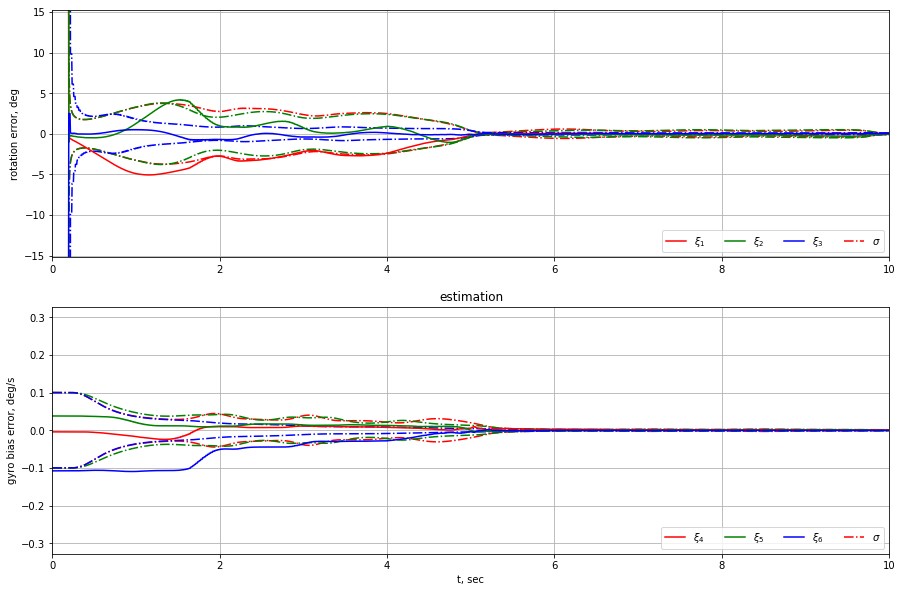

x0 [-0.50227713 -0.18813357  0.2152099   0.00600461  0.02381248  0.04773163]
error statistics after 5 seconds
mean (deg)	:    -0.0698 roll,    -0.0732 pitch,     0.0124 yaw
std  (deg)	:     0.0619 roll,     0.0619 pitch,     0.0168 yaw


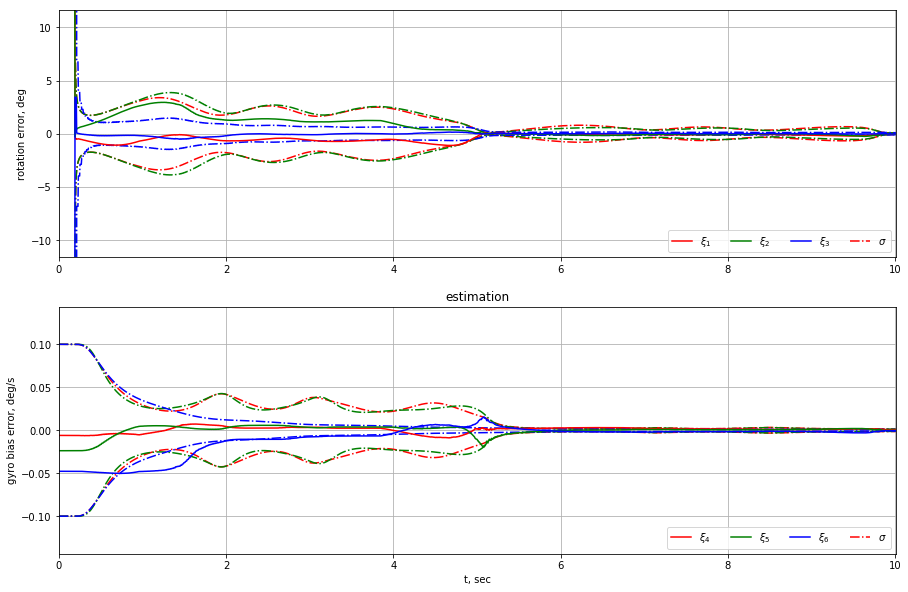

x0 [-0.46202857  1.07794031  0.73147268 -0.05546221  0.09649194 -0.01860731]
error statistics after 5 seconds
mean (deg)	:    -0.0670 roll,    -0.0662 pitch,     0.0295 yaw
std  (deg)	:     0.0684 roll,     0.0502 pitch,     0.0291 yaw


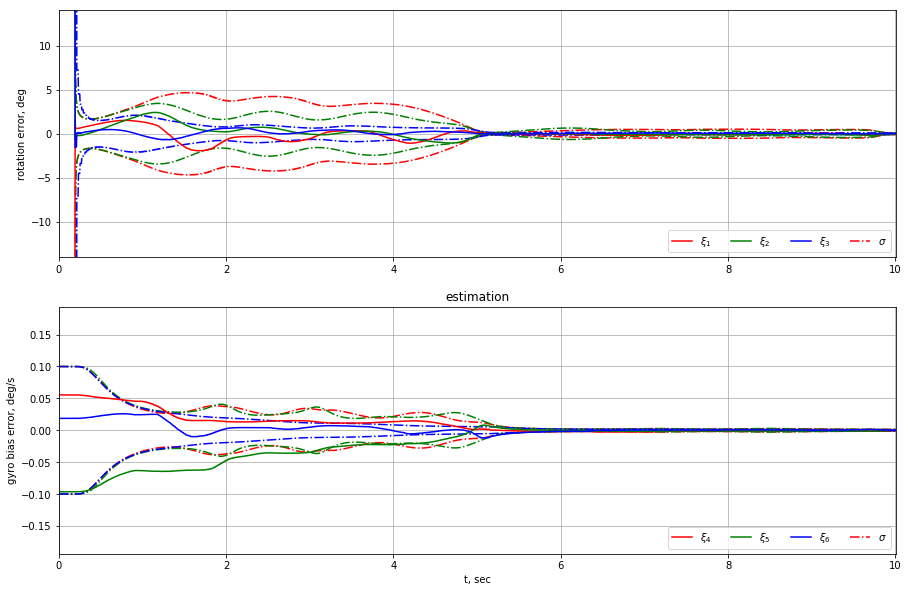

In [23]:
sim_params['tf'] = 10
for i in range(3):
    sim_params['x0'] = np.random.randn(6)*np.array([1, 1, 1, 0.1, 0.1, 0.1])
    print('x0', sim_params['x0'])
    hist = sim(sim_funcs, sim_params, do_init=True)
    mean, std = analyze_hist(hist, sim_params['tf']/2)
    #if np.max(np.fabs(mean)) > 1 or np.max(np.fabs(mean)) > 1:
    plot_hist(hist, att=False, meas=False)
    sys.stdout.flush()

In [24]:
#%prun -l 5 hist = sim(sim_funcs, sim_params) #run this to profile, 10% slower
sim_params['tf'] = 3

# particularly tough x0
sim_params['x0'] = np.array([-0.3393284,   0.96324758, -0.12871277,  0.02793016, -0.07388032,  0.07519002])

This initial conditon has poor convergence initially, but still converges eventually.

100%|██████████| 601/601 [00:00<00:00, 843.52it/s]


error statistics after 2 seconds
mean (deg)	:    43.5492 roll,   -62.5960 pitch,     5.3329 yaw
std  (deg)	:    73.9201 roll,    51.0587 pitch,    93.3614 yaw


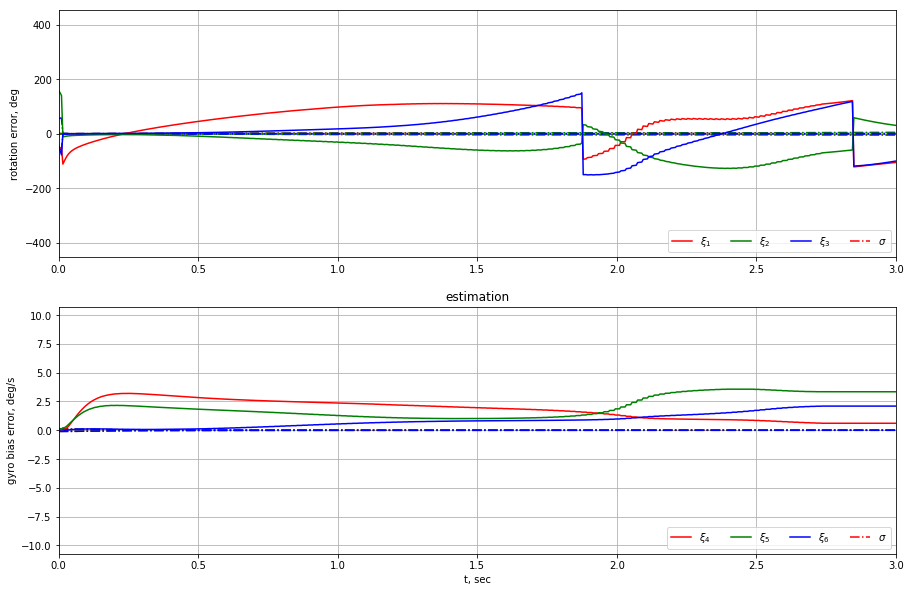

In [25]:
hist = sim(sim_funcs, sim_params, enable_progress=True, do_init=False)
analyze_hist(hist, sim_params['tf']/2)
plot_hist(hist, meas=False, att=False)

This is resolved with initialization.

100%|██████████| 4001/4001 [00:04<00:00, 835.59it/s]


error statistics after 10 seconds
mean (deg)	:    -0.0463 roll,    -0.0534 pitch,    -0.0045 yaw
std  (deg)	:     0.0276 roll,     0.0101 pitch,     0.0166 yaw


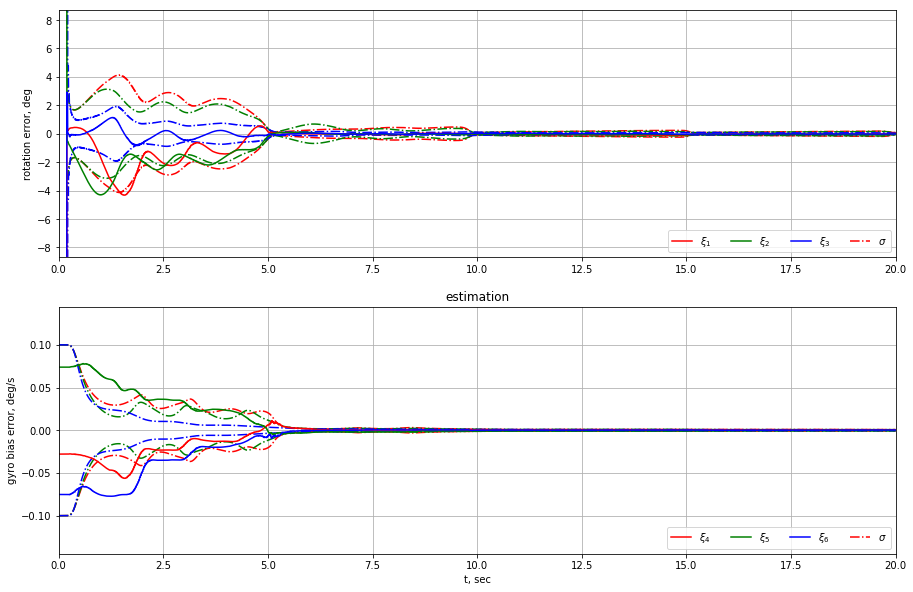

In [26]:
sim_params['tf'] = 20
hist = sim(sim_funcs, sim_params, enable_progress=True, do_init=True)
analyze_hist(hist, sim_params['tf']/2)
plot_hist(hist, meas=False, att=False)

Save data to csv file.

In [27]:
index = pd.Float64Index(np.reshape(hist['t'], -1))
columns = []
data = {}
for k in hist.keys():
    if k is 't':
        continue
    vals = hist[k]
    for i in range(vals.shape[1]):
        data['{:s}_{:d}'.format(k, i)] = hist[k][:, i]
res = pd.DataFrame(data=data, index=index)
with open('results.csv', 'w') as f:
    f.write(res.to_csv())

Text(0,0.5,'deg/s')

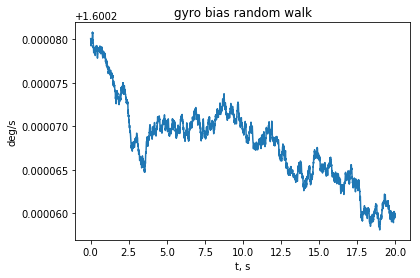

In [28]:
np.rad2deg(res.x_3).plot()
plt.title('gyro bias random walk');
plt.xlabel('t, s')
plt.ylabel('deg/s')

# Code Generation

All of the functions that will be generated for the embedded system are listed below:

In [29]:
func

{'mrp_shadow': Function(mrp_shadow:(r[3])->(r_s[3]) SXFunction),
 'mrp_to_quat': Function(mrp_to_quat:(r[3])->(q[4]) SXFunction),
 'quat_to_euler': Function(quat_to_euler:(q[4])->(e[3]) SXFunction),
 'predict_x_W': Function(predict_x_W:(x0[6],W0[6x6,21nz],omega_b[3],std_gyro,sn_gyro_rw,dt)->(x1[6],W1[6x6,21nz]) SXFunction),
 'correct_accel': Function(correct_accel:(x_h[6],W[6x6,21nz],y_b[3],omega_b[3],std_accel,std_accel_omega)->(x_accel[6],W_accel[6x6,21nz]) SXFunction),
 'correct_mag': Function(correct_mag:(x_h[6],W[6x6,21nz],y_b[3],decl,std_mag)->(x_mag[6],W_mag[6x6,21nz]) SXFunction),
 'init': Function(init:(g_b[3],B_b[3],decl,std_x0[6])->(init_valid,x0[6],W0[6x6,21nz]) SXFunction)}

In [30]:
# code generation
gen = ca.CodeGenerator('casadi_att_lgpekf.c', {'main': False, 'mex': False, 'with_header': True, 'with_mem': True})
for f_name in func:
    gen.add(func[f_name])

install_dir = os.path.abspath(os.path.join(os.environ['HOME'], 'git/phd/px4/src/modules/cei/gen/att_lgpekf'))
if not os.path.exists(install_dir):
    os.mkdir(install_dir)
gen.generate(install_dir + os.path.sep)

'/home/jgoppert/git/phd/px4/src/modules/cei/gen/att_lgpekf/casadi_att_lgpekf.c'